# Stars, Galaxies and Quasars Classification

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')
#import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

### Data Acquisition

In [2]:
#sdss_df = pd.read_csv('Skyserver_SQL2_27_2018 6_51_39 PM.csv', skiprows=1)
sdss_df = pd.read_csv('../DataSets/Skyserver_SQL2_27_2018 6_51_39 PM.csv', skiprows=0)
sdss_df

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.237650e+18,131.316413,51.539547,18.81777,17.47053,16.91508,16.68305,16.50570,1345,301,3,161,5.033450e+17,GALAXY,0.027583,447,51877,246
9996,1.237650e+18,131.306083,51.671341,18.27255,17.43849,17.07692,16.71661,16.69897,1345,301,3,162,5.033400e+17,GALAXY,0.117772,447,51877,228
9997,1.237650e+18,131.552562,51.666986,18.75818,17.77784,17.51872,17.43302,17.42048,1345,301,3,162,8.222620e+18,STAR,-0.000402,7303,57013,622
9998,1.237650e+18,131.477151,51.753068,18.88287,17.91068,17.53152,17.36284,17.13988,1345,301,3,163,5.033400e+17,GALAXY,0.014019,447,51877,229


### Data Exploration

#### Basic stats about our dataset

Let's take a first look at our dataset to see what we're working with!

In [3]:
sdss_df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


We can tell that we have all the features as described in the above query. 

We notice that there are no categorical features at all - besides the class column. As some machine learning models can't handle categorical feature columns at all, we will encode this column to be a numerical column later on.

Let's find out about the types of columns we have:

**Information about the dataset**

In [4]:
sdss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


The dataset has 10000 examples, 17 feature columns and 1 target column. 8 of the 17 features are 64 bit integers, 1 feature is an unsigned 64 bit integer, 8 are 64 bit floats and the target column is of the type object. 

**Description about the dataset**

In [5]:
sdss_df.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.237650e+18,175.529987,14.836148,18.619355,17.371931,16.840963,16.583579,16.422833,981.034800,301.0,3.648700,302.380100,1.645022e+18,0.143726,1460.986400,52943.533300,353.069400
std,1.577039e+05,47.783439,25.212207,0.828656,0.945457,1.067764,1.141805,1.203188,273.305024,0.0,1.666183,162.577763,2.013998e+18,0.388774,1788.778371,1511.150651,206.298149
min,1.237650e+18,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,308.000000,301.0,1.000000,11.000000,2.995780e+17,-0.004136,266.000000,51578.000000,1.000000
25%,1.237650e+18,157.370946,-0.539035,18.178035,16.815100,16.173333,15.853705,15.618285,752.000000,301.0,2.000000,184.000000,3.389248e+17,0.000081,301.000000,51900.000000,186.750000
50%,1.237650e+18,180.394514,0.404166,18.853095,17.495135,16.858770,16.554985,16.389945,756.000000,301.0,4.000000,299.000000,4.966580e+17,0.042591,441.000000,51997.000000,351.000000
75%,1.237650e+18,201.547279,35.649397,19.259232,18.010145,17.512675,17.258550,17.141447,1331.000000,301.0,5.000000,414.000000,2.881300e+18,0.092579,2559.000000,54468.000000,510.000000
max,1.237650e+18,260.884382,68.542265,19.599900,19.918970,24.802040,28.179630,22.833060,1412.000000,301.0,6.000000,768.000000,9.468830e+18,5.353854,8410.000000,57481.000000,1000.000000


From the above table we can tell that are no missing values at all. This means: **no imputing!**

We also notice that most of the features stay within a reasonable scale when comparing values within **only one** column. We can recognize this from the min, max and quartil rows.

**Counting Values**

In [6]:
sdss_df['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

The most objects (50%) are galaxies, a little less (40%) are stars and only around (10%) of the rows are classified as QSOs.

#### First Data Filtering

In [7]:
sdss_df.columns.values

array(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun',
       'camcol', 'field', 'specobjid', 'class', 'redshift', 'plate',
       'mjd', 'fiberid'], dtype=object)

There is no need to know everything about stars, galaxy or quasars - yet we can already tell which features are **unlikely** to be related to the target variable 'class'.

**objid** and **specobjid** are just identifiers for accessing the rows back when they were stored in the original databank. Therefore we will not need them for classification as they are not related to the outcome.

Even more: The features 'run', 'rerun', 'camcol' and 'field' are values which describe parts of the camera at the moment when making the observation, e.g. 'run' represents the corresponding scan which captured the oject.

Source: http://www.sdss3.org/dr9/imaging/imaging_basics.php

We will drop these columns as any correlation to the outcome would be coincidentally.

In [8]:
sdss_df.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid'], axis=1, inplace=True)
sdss_df.head(1)

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid
0,183.531326,0.089693,19.47406,17.0424,15.94699,15.50342,15.22531,STAR,-0.000009,3306,54922,491


### Univariate Analysis

#### Redshift

To start the univariate analysis we will plot histograms for the 'redshift' feature column for each class.

This will tell us how the redshift values are distributed over their range.

C:\Users\USER\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


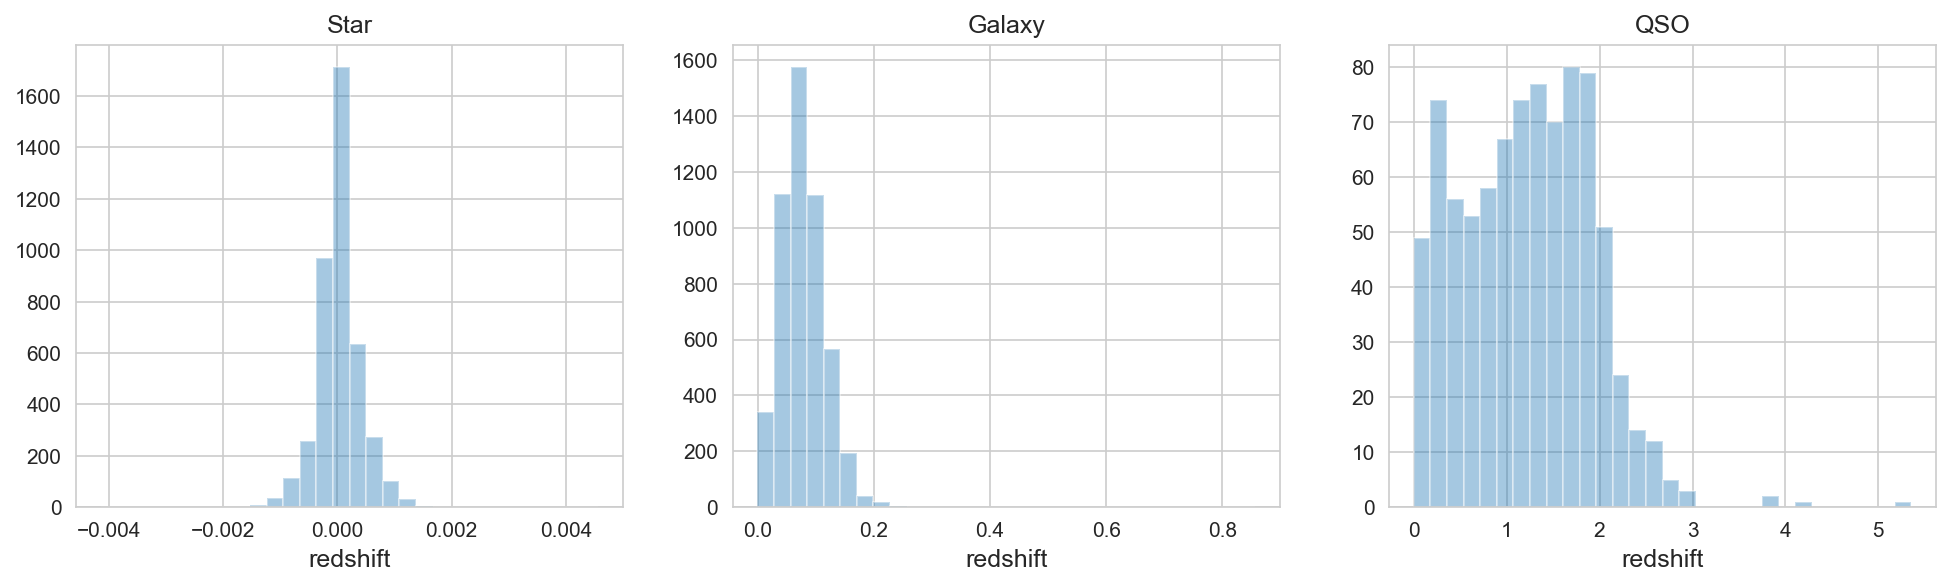

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(sdss_df[sdss_df['class']=='STAR'].redshift, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(sdss_df[sdss_df['class']=='GALAXY'].redshift, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(sdss_df[sdss_df['class']=='QSO'].redshift, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('QSO')

This is an interesting result.

We can cleary tell that the redshift values for the classes quite differ. 

* **Star:** The histogram looks like a truncated zero-centered normal distribution.

* **Galaxy:** The redshift values may come from a slightly right-shifted normal distribution which is centered around 0.075.

* **QSO:** The redshift values for QSOs are a lot more uniformly distributed than for Stars or Galaxies. They are roughly evenly distributed from 0 to 3, than the occurences decrease drastically. For 4 oder ~5.5 there are some outliers.

**The redshift can be an estimate(!) for the distance from the earth to a object in space.**

Hence the distplot tells us that most of the stars observed are somewhat closer to the earth than galaxies or quasars. Galaxies tend to be a little further away and quasars are distant from very close to very far.  

Possible rookie explanation: Since galaxies and quasars radiate stronger due to their size and physical structure, they can be observed from further away than "small" stars.

As we can distinct the classes from each other just based on this column - 'redshift' is very likely to be helping a lot classifying new objects.

#### dec

Let's lvplot the values of dec (Recall: position on celestial equator)!

Text(0.5, 1.0, 'dec')

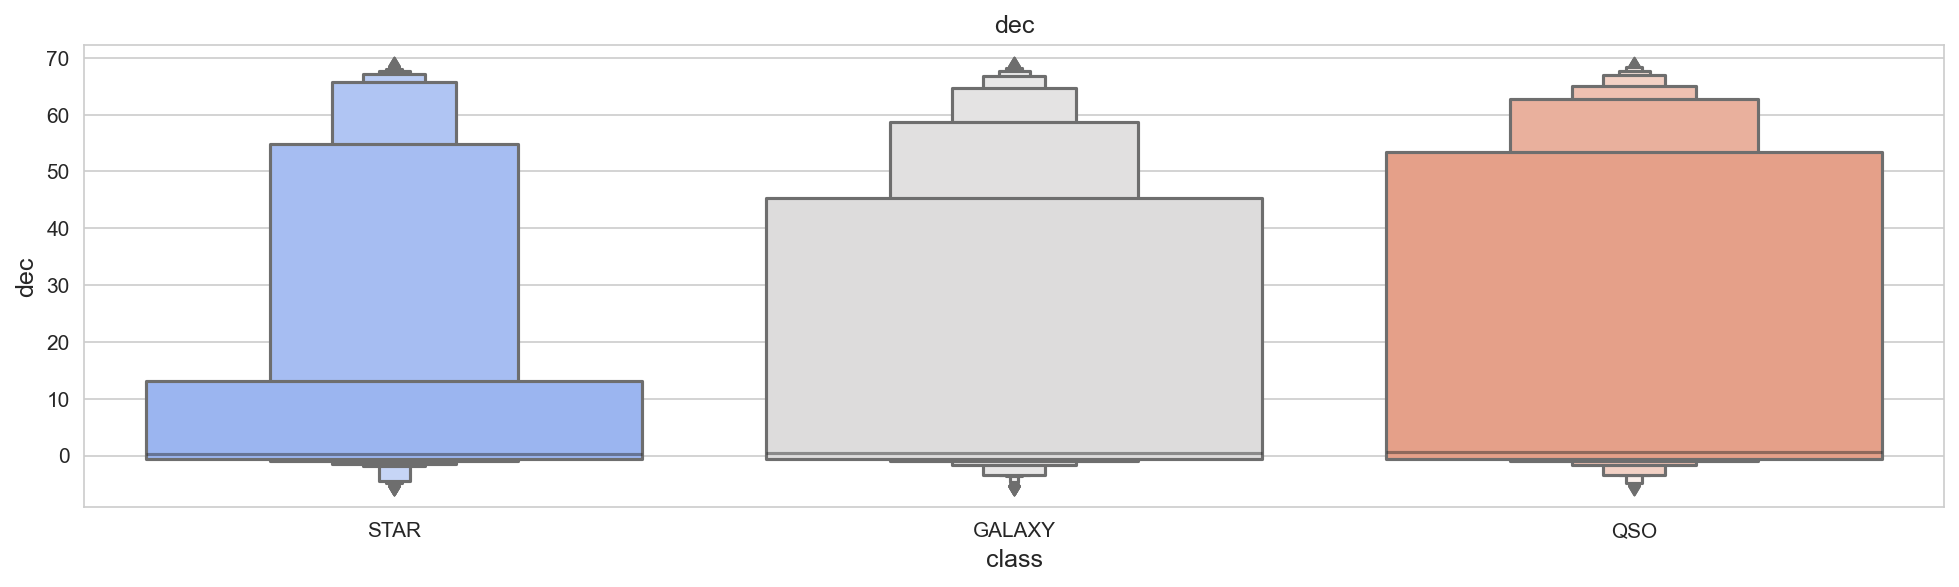

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16, 4))
ax = sns.boxenplot(x=sdss_df['class'], y=sdss_df['dec'], palette='coolwarm')
ax.set_title('dec')

**First of all: what does this plot tell us?**

The Letter value (LV) Plot show us an estimate of the distribution of the data. It shows boxes which relate to the amount of values within the range of values inside the box.

In this case we can observe a clear distinction between Stars and the other two classes. The difference between Galaxies and Quasars is smaller.

* **Star:** The largest part of the data points lay within a 0 to 10 range. Another large part consists of values between about 10 to 55. Only small amounts of the data are lower or higher than these ranges.

* **Galaxy:** The largest part of values lays between 0 and 45. There is a smaller amount of values in the range of 45 to 60. The rest of the data has smaller or higher values.

* **QSO:** This plot looks quite similiar to the GALAXY plot. Only the amount of data points in the range of 0 to 60 is even bigger.

Side Note: The fact that the distribution of dec values of galaxies und quasar objects is almost the same might indicate that one can find both galaxies and quasars at smiliar positions in the night sky.

### Multivariate Analysis

#### u,g,r,i,z filters

Recall: u, g, r, i, z represent the different wavelengths which are used to capture the observations.

Let's find out how much they are correlated.

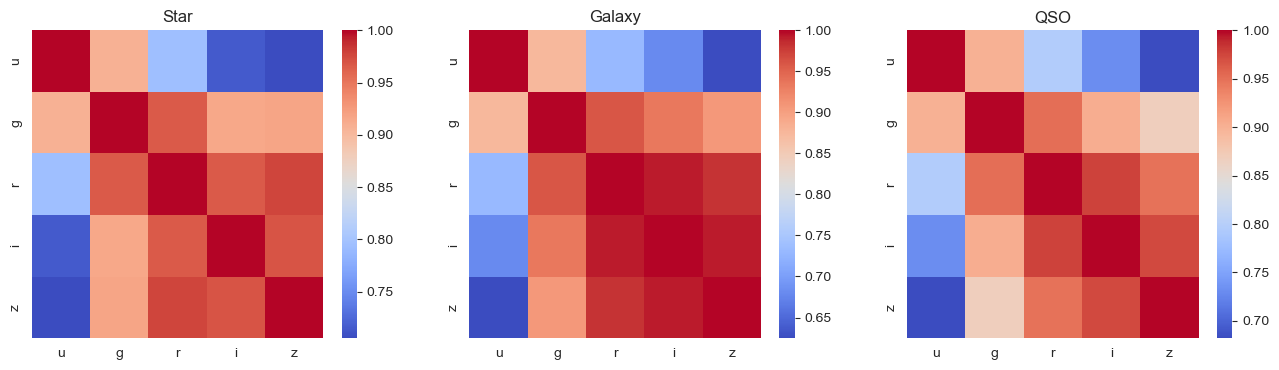

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
fig.set_dpi(100)
ax = sns.heatmap(sdss_df[sdss_df['class']=='STAR'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[0], cmap='coolwarm')
ax.set_title('Star')
ax = sns.heatmap(sdss_df[sdss_df['class']=='GALAXY'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[1], cmap='coolwarm')
ax.set_title('Galaxy')
ax = sns.heatmap(sdss_df[sdss_df['class']=='QSO'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[2], cmap='coolwarm')
ax = ax.set_title('QSO')

Right of the top we observe that the correlation matrices look very similiar for every class.

We can tell that there are high correlations between the different bands. This feels not really suprising - intuitively one would think that if one of the bands captures some object, the other bands should capture something aswell.

Therefore it is interesting to see that band 'u' is less correlated to the other bands. 

Remember: u, g, r, i, z capture light at wavelengths of 354, 476, 628, 769 and 925 nm.

This might indicates that galaxies, stars and quasar objects shine brighter at wavelengths from 476 - 925 nm. Don't quote me on that though.

**But:** as we can see - the correlation is roughly the same for every class...the different bands behave the same for the different classes!

#### Right ascension (ra) and declination (dec) 

We will now plot the right ascension versus the declination depending on the class 

C:\Users\USER\anaconda3\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Equatorial coordinates')

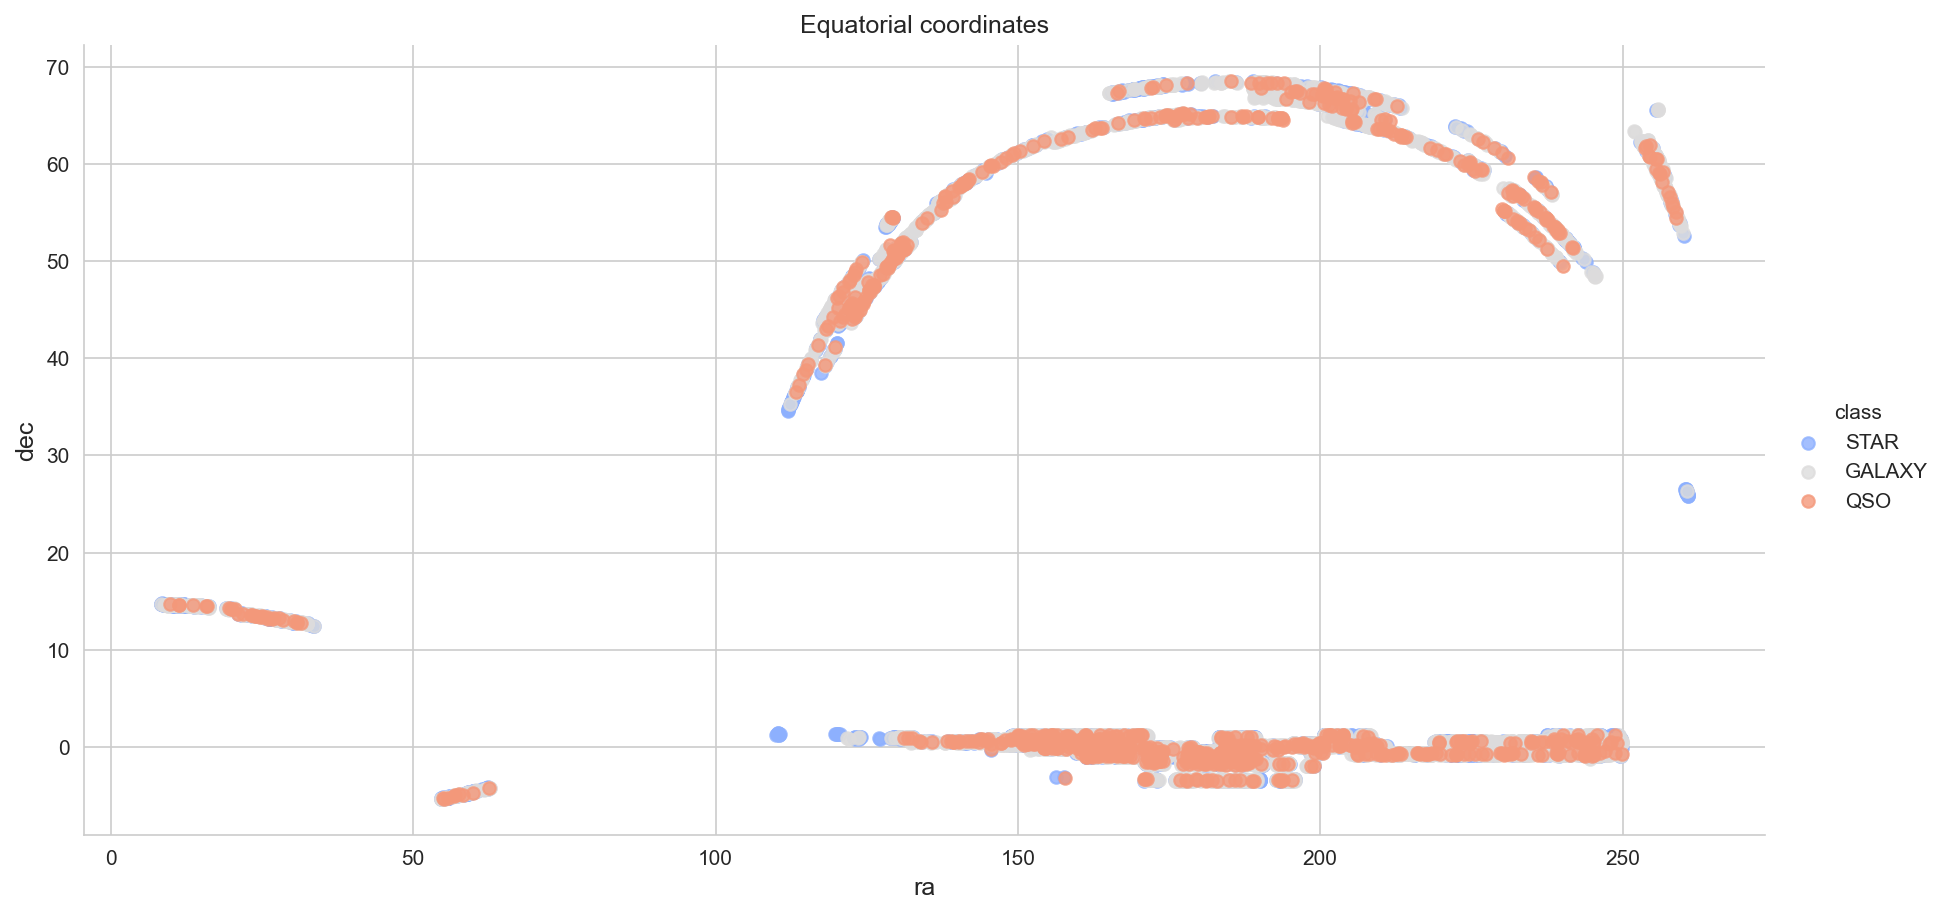

In [12]:
sns.lmplot(x='ra', y='dec', data=sdss_df, hue='class', fit_reg=False, palette='coolwarm', size=6, aspect=2)
plt.title('Equatorial coordinates')

As we can clearly observe the equatorial coordinates do not differ significantly between the 3 classes. There are some outliers for stars and galaxies but for the bigger part the coordinates are within the same range.

Why is that?

All SDSS images cover the same area of the sky. The plot above tells us that stars, galaxies and quasars are observed equally at all coordinates within this area. So whereever the SDSS "looks" - the chance of observing a star or galaxy or quasar is always the same.  

**This contradicts our interpretation of the letter value plot of dec from the univariate analysis.**


-------------------------
### Feature Engineering

#### u, g, r, i, z

We will now reduce the amount of dimensions by replacing the different bands 'u', 'g', 'r', 'i' and 'z' by a linear combination with only 3 dimensions using **Principal Component Analysis**.

**Principal Component Analysis:**

n observations with p features can be interpreted as n points in a p-dimensional space. PCA aims to project this space into a q-dimensional subspace (with q<p) with as little information loss as possible. 

It does so by finding the q directions in which the n points vary the most (--> the principal components). It then projects the original data points into the q-dimensional subspace. PCA returns a n x q dimensional matrix. 

Using PCA on our data will decrease the amount of operations during training and testing.

In [13]:
sdss_df_fe = sdss_df

# encode class labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(sdss_df_fe['class'])
sdss_df_fe['class'] = y_encoded

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(sdss_df_fe[['u', 'g', 'r', 'i', 'z']])

# update dataframe 
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
sdss_df_fe.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
sdss_df_fe.head()

,ra,dec,class,redshift,plate,mjd,fiberid,PCA_1,PCA_2,PCA_3
0,183.531326,0.089693,2,-0.000009,3306,54922,491,-1.507202,-1.377293,-0.265119
1,183.598370,0.135285,2,-0.000055,323,51615,541,-0.195758,-0.028410,-0.155695
2,183.680207,0.126185,0,0.123111,287,52023,513,1.297604,-0.590023,0.140338
3,183.870529,0.049911,2,-0.000111,3306,54922,510,-1.446117,0.566685,-0.009272
4,183.883288,0.102557,2,0.000590,3306,54922,512,-0.849271,1.287505,-0.397689


--------------------
## Classification Models

#### Feature Scaling

We will now train different models on this dataset. 

Scaling all values to be within the (0, 1) interval will reduce the distortion due to exceptionally high values and make some algorithms converge faster.

In [14]:
scaler = MinMaxScaler()
sdss = scaler.fit_transform(sdss_df_fe.drop('class', axis=1))

We will  split the data into a training and a test part. The models will be trained on the training data set and tested on the test data set

In [15]:
X_train, X_test, y_train, y_test = train_test_split(sdss, sdss_df_fe['class'], test_size=0.33)

### KNN algorithm 

In [16]:
knn = KNeighborsClassifier()
training_start = time.perf_counter()
knn.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = knn.predict(X_test)
prediction_end = time.perf_counter()
acc_knn = (preds == y_test).sum().astype(float) / len(preds)*100
knn_train_time = training_end-training_start
knn_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: %3.2f" % (acc_knn))
print("Time consumed for training: %4.3f seconds" % (knn_train_time))
print("Time consumed for prediction: %6.5f seconds" % (knn_prediction_time))

Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: 92.45
Time consumed for training: 0.013 seconds
Time consumed for prediction: 0.16107 seconds


C:\Users\USER\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


### Naive Bayes

In [17]:
from sklearn.preprocessing import MaxAbsScaler
scaler_gnb = MaxAbsScaler()
sdss = scaler_gnb.fit_transform(sdss_df_fe.drop('class', axis=1))
X_train_gnb, X_test_gnb, y_train_gnb, y_test_gnb = train_test_split(sdss, sdss_df_fe['class'], test_size=0.33)

gnb = GaussianNB()
training_start = time.perf_counter()
gnb.fit(X_train_gnb, y_train_gnb)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = gnb.predict(X_test_gnb)
prediction_end = time.perf_counter()
acc_gnb = (preds == y_test_gnb).sum().astype(float) / len(preds)*100
gnb_train_time = training_end-training_start
gnb_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: %3.2f" % (acc_gnb))
print("Time consumed for training: %4.3f seconds" % (gnb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (gnb_prediction_time))

Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: 97.52
Time consumed for training: 0.002 seconds
Time consumed for prediction: 0.00104 seconds


### XGBoost

In [18]:
xgb = XGBClassifier(n_estimators=100)
training_start = time.perf_counter()
xgb.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb.predict(X_test)
prediction_end = time.perf_counter()
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

XGBoost's prediction accuracy is: 99.09
Time consumed for training: 0.555
Time consumed for prediction: 0.00700 seconds


### Scitkit-Learn's Random Forest Classifier

In [19]:
rfc = RandomForestClassifier(n_estimators=10)
training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = rfc.predict(X_test)
prediction_end = time.perf_counter()
acc_rfc = (preds == y_test).sum().astype(float) / len(preds)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 98.97
Time consumed for training: 0.138 seconds
Time consumed for prediction: 0.00386 seconds


### Support Vector Machine Classifier

In [20]:
svc = SVC()
training_start = time.perf_counter()
svc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = svc.predict(X_test)
prediction_end = time.perf_counter()
acc_svc = (preds == y_test).sum().astype(float) / len(preds)*100
svc_train_time = training_end-training_start
svc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_svc))
print("Time consumed for training: %4.3f seconds" % (svc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (svc_prediction_time))

Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: 94.27
Time consumed for training: 0.415 seconds
Time consumed for prediction: 0.46677 seconds


### Model Comparison
Let's compare the results. We will create a table for a more comprehensive overview.

In [21]:
results = pd.DataFrame({
    'Model': ['KNN', 'Naive Bayes', 
              'XGBoost', 'Random Forest', 'SVC'],
    'Score': [acc_knn, acc_gnb, acc_xgb, acc_rfc, acc_svc],
    'Runtime Training': [knn_train_time, gnb_train_time, xgb_train_time, rfc_train_time, 
                         svc_train_time],
    'Runtime Prediction': [knn_prediction_time, gnb_prediction_time, xgb_prediction_time, rfc_prediction_time,
                          svc_prediction_time]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Score,Runtime Training,Runtime Prediction
Model,,,
XGBoost,99.090909,0.554807,0.006999
Random Forest,98.969697,0.138237,0.003863
Naive Bayes,97.515152,0.002211,0.001042
SVC,94.272727,0.415391,0.466773
KNN,92.454545,0.013143,0.161074


### Conclusion

We can see that both XGBoost and Scikit-Learn's Random Forest Classifier could achieve very high accuracy.

Gaussian Naive Bayes achieves just a little less accuracy but needs a very little amount of time to both train and predict data.

KNN performs about 5% worse than Naive Bayes.

The Support Vector Machine Classifier has the worst accuracy, plus takes the most of time for its operations.

***********
### Now let's increase the accuracy of the model using K Fold Cross Validation

We will no perform k fold cross valdiation for the top 2 classifiers, i.e. XGBoost & Random Forest.

We do this to get a more realistic result by testing the performance for 10 different train and test datasets and averaging the results. 

Cross validation ensures that the above result is not arbitary and gives a more reliable performance check.

### Scikit-Learn's Random Forest Classifier

In [22]:
from sklearn.model_selection import cross_val_score
rfc_cv = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rfc_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.99402985 0.9880597  0.99253731 0.99552239 0.99701493 0.99253731
 0.99253731 0.99253731 0.98955224 0.99104478]
Mean: 0.9925373134328357
Standard Deviation: 0.0024974926165196344


### XGBoost

In [23]:
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.99701493 0.99253731 0.99104478 0.99701493 0.99701493 0.99552239
 0.99850746 0.99402985 0.98955224 0.99104478]
Mean: 0.9943283582089553
Standard Deviation: 0.002970111752557077


**Observation**

Cross validating the models showed that the accuracy values were in fact not arbitary and proofed that both models are performing very well. 

**XGBoost showed a higher mean and lower standard deviation than the Scikit-Learn RFC.**

A high mean corresponds to a more stable performance and a low standard deviation corresponds to smaller range of results. 



### Feature Importance

Decision Trees have the unique property of being able to order features by their ability to split between the classes.

We will now visualize the features and their splitting ability.

In [24]:
importances = pd.DataFrame({
    'Feature': sdss_df_fe.drop('class', axis=1).columns,
    'Importance': xgb.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

,Importance
Feature,
redshift,0.935906
PCA_3,0.021520
PCA_2,0.009080
PCA_1,0.008789
plate,0.006734
mjd,0.005034
ra,0.004624
fiberid,0.004585
dec,0.003728


<AxesSubplot:xlabel='Feature'>

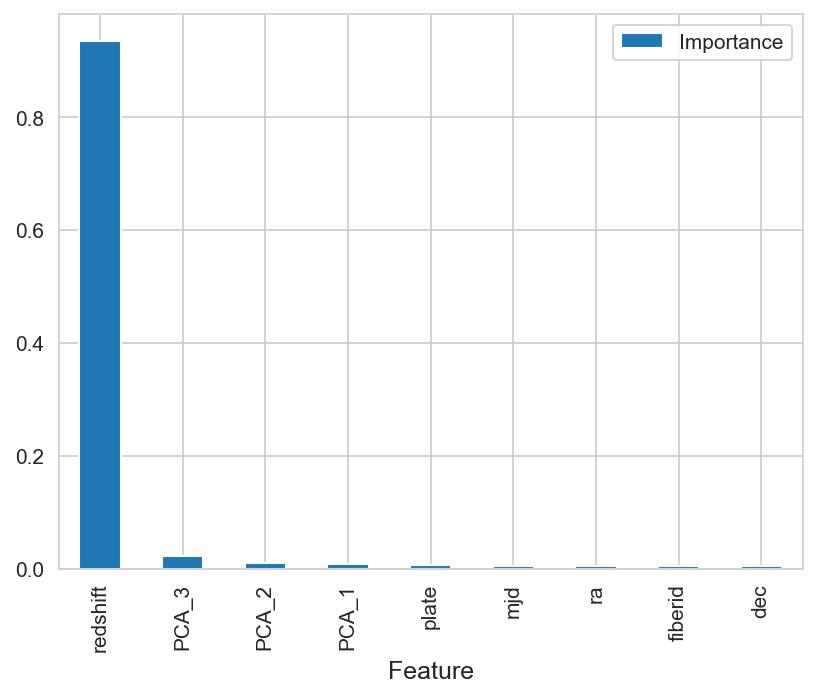

In [25]:
importances.plot.bar()

Here we can clearly see how PCA helped to improve the performance of our predictors as 2 of the principal components are in the top 3 features.

The best (in terms of being able to split classes) is redshift.

Mjd is the feature with the lowest importance during the classification process, we will therefore drop it from the dataframe.

Let's drop the column from the dataframe and rescale it. Since XGBoost requires the class to be discrete, we will re-add it manually afterwards.

In [26]:
scaler = MinMaxScaler()
sdss = pd.DataFrame(scaler.fit_transform(sdss_df_fe.drop(['mjd', 'class'], axis=1)), columns=sdss_df_fe.drop(['mjd', 'class'], axis=1).columns)
sdss['class'] = sdss_df_fe['class']

In [27]:
sdss.head()

,ra,dec,redshift,plate,fiberid,PCA_1,PCA_2,PCA_3,class
0,0.693832,0.074025,0.000770,0.373281,0.490490,0.385886,0.069348,0.387685,2
1,0.694098,0.074642,0.000762,0.006999,0.540541,0.448110,0.215264,0.415556,2
2,0.694422,0.074519,0.023749,0.002579,0.512513,0.518964,0.154511,0.490959,0
3,0.695175,0.073487,0.000751,0.373281,0.509510,0.388785,0.279638,0.452852,2
4,0.695225,0.074199,0.000882,0.373281,0.511512,0.417103,0.357613,0.353918,2


### Summary

We trained different machine learning models to solve this classification problems. Without any further hyperparameter tuning XGBoost and Scikit-Learn's Random Forest Classifier performed the best.

As XGBoost showed a little higher accuracy in most of the tests, we will continue only with this classifier.

------------------------------------
Let's dive deep into the XgBoost Algorithm!
### XGBoost - Finding the best hyperparameters

Now it's time to look for the optimal hyperparameters - what does this mean?

We will test our chosen model with different values for (almost) each of its tuning parameters and give back the parameters with which the model performed best.

**The actual searching for optimal parameters is not done in this notebook since the operations can take some time and parallel editing would not be possible.**

We will write our transformed data set to disk so the tuning scripts can access it. 

In [28]:
sdss.to_csv('sdss_data.csv')

The best parameters for prediction as found by the tuning tests are:

- max_depth = 5
- min_child_weight = 1
- gamma = 0
- subsample = 0.8
- colsample_bytree = 0.8
- reg_alpha = 0.005

### XGBoost - Testing optimal hyperparameters

The following model implements the best performing model with optimal parameters evaluated by the hyperparameter tuning. We will expect the model to perform even better than before.


In [29]:
X_train, X_test, y_train, y_test = train_test_split(sdss.drop('class', axis=1), sdss['class'],
                                                   test_size=0.33)

In [30]:
xgboost = XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=100, gamma=0, 
                        min_child_weight=1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.005)

xgboost.fit(X_train, y_train)
preds = xgboost.predict(X_test)

accuracy = (preds == y_test).sum().astype(float) / len(preds)*100

print("XGBoost's prediction accuracy WITH optimal hyperparameters is: %3.2f" % (accuracy))

XGBoost's prediction accuracy WITH optimal hyperparameters is: 99.33


**The parameter tuning did not improve the accuracy as excpected. We will therefore do a cross validation to test to get a more reliable result.**

In [31]:
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.99552239 0.99850746 0.99402985 0.98358209 0.99253731 0.99253731
 0.99104478 0.99402985 0.98955224 0.99552239]
Mean: 0.992686567164179
Standard Deviation: 0.00386045288250078


Depending on the run the cross validation results vary from a little lower and a little better than before. 

This indicates that the parameter tuning was not as effective as expected - this could mean that XGBoost was actually close to its maximum performance capability on this data set.

As we still have a good performance we will now continue with further evaluation of the performance of our model!

### XGBoost - Evaluation

#### Confusion Matrix

In [32]:
unique, counts = np.unique(sdss['class'], return_counts=True)
dict(zip(unique, counts))

{0: 4998, 1: 850, 2: 4152}

In [33]:
predictions = cross_val_predict(xgb, sdss.drop('class', axis=1), sdss['class'], cv=3)
confusion_matrix(sdss['class'], predictions)

array([[4964,   26,    8],
       [  25,  824,    1],
       [   6,    0, 4146]], dtype=int64)

The first row shows that out of 4998 stars, **4962 were classified correctly as stars**. 29 stars were classified incorrectly as galaxies and 7 stars were classified incorrectly as quasars.

The second row shows out of 850 quasars **827 were classified correctly**. 22 qsos were classified incorrectly as stars and 1 quasar was classified as galaxy.

The last row tells us that out of 4152 galaxies **4147 were classified correctly.**. 5 galaxies were classified incorrectly as star.

In total: 

We have only 64 objects which were classified incorrectly. Most of the objects were recognized as what they are.

#### Precision & Recall

In [34]:
print("Precision:", precision_score(sdss['class'], predictions, average='micro'))
print("Recall:",recall_score(sdss['class'], predictions, average='micro'))

Precision: 0.9934
Recall: 0.9934


Precision is the fraction of events where the algorithm classified an object of type **t** correctly out of all occurences of the algorithm classifying objects of type **t**.

Recall is the fraction of events where the algorithm classified an object of type **t** correctly when the true type of that object was actually **t**.

**Precision in our case:**

For every class its calculated how many objects were classified as stars (or galaxies or quasars) in relation to the amount of correct star (or galaxies or quasars) predictions. The results are averaged --> 99.36%.

**Recall in our case:**

For every class its calculated how many objects were classified as stars (or galaxies or quasars) in relation to the total amount of predictions where the object actually was a star (or galaxy or quasar). The results are averaged --> 99.36%.

In both cases our algorithm did a very good job. The highest precision or recall value a predictor can have is 1.0.

#### F1-Score

One can combine precision and recall into one score, which is called the F-score. The F-score is computed with the harmonic mean of precision and recall. Note that it assigns much more weight to low values. As a result of that, the classifier will only get a high F-score, if both recall and precision are high.

In [35]:
print("F1-Score:", f1_score(sdss['class'], predictions, average='micro'))

F1-Score: 0.9934


As precision and recall have the same value the F1-Score has automatically the same value too. Again, we are very close to 1.0 which indicates strong performance.